<a href="https://colab.research.google.com/github/SHEHAN-120/Fine-Tuning-BERT-for-Twitter-Sentiment/blob/main/sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Libiraries

In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv")

In [4]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [5]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


,0
text,0
label,0
label_name,0


In [6]:
df['label'].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


## Dataset Analysics

In [7]:
import matplotlib.pyplot as plt

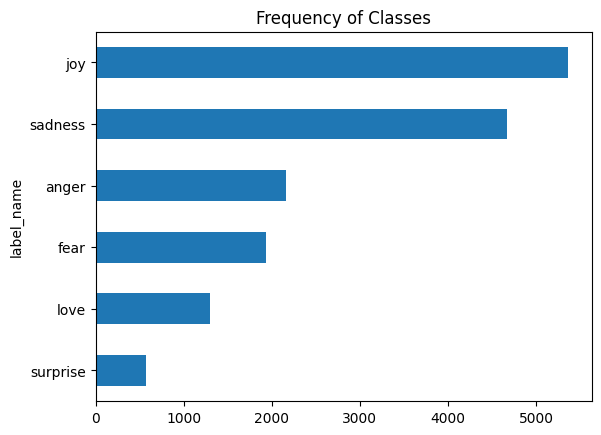

In [8]:
label_counts=df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'words per tweet'}, xlabel='label_name'>

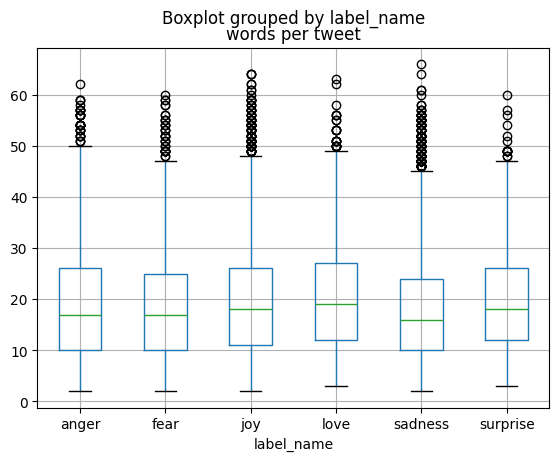

In [9]:
df['words per tweet']=df['text'].str.split().apply(len)
df.boxplot("words per tweet",by="label_name")

## Text to Token Conversion

In [10]:
from transformers import AutoTokenizer

model_ckpt="bert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

text="I Love machine learning! Tokenization is awesome!!"
encoded_text=tokenizer(text)
print(encoded_text)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [11]:
len(tokenizer.vocab),tokenizer.vocab_size,tokenizer.model_max_length

(30522, 30522, 512)

## Data Loader and Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

train,test=train_test_split(df,test_size=0.3,stratify=df['label_name'])
test,validation=train_test_split(test,test_size=1/3,stratify=test['label_name'])
train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [13]:
from datasets import Dataset,DatasetDict

dataset=DatasetDict(
    {'train':Dataset.from_pandas(train,preserve_index=False),
     'test':Dataset.from_pandas(test,preserve_index=False),
     'validation':Dataset.from_pandas(validation,preserve_index=False)
     }
)

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 1600
    })
})

## Tokenization of the Sentiment Data

In [15]:
dataset['train'][0],dataset['train'][1]

({'text': 'i get the nasty feeling that my posts are boring the pants off everyone',
  'label': 0,
  'label_name': 'sadness',
  'words per tweet': 14},
 {'text': 'i guess im just feeling a little rebellious',
  'label': 3,
  'label_name': 'anger',
  'words per tweet': 8})

In [16]:
def tokenize(batch):
  temp=tokenizer(batch['text'],padding=True,truncation=True)
  return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2131, 1996, 11808, 3110, 2008, 2026, 8466, 2024, 11771, 1996, 6471, 2125, 3071, 102], [101, 1045, 3984, 10047, 2074, 3110, 1037, 2210, 22614, 102, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]}


In [17]:
emotion_encoded=dataset.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [18]:
label2id={x['label_name']:x['label'] for x in dataset['train']}
id2label={v:k for k,v in label2id.items()}

label2id,id2label

({'sadness': 0, 'anger': 3, 'joy': 1, 'love': 2, 'surprise': 5, 'fear': 4},
 {0: 'sadness', 3: 'anger', 1: 'joy', 2: 'love', 5: 'surprise', 4: 'fear'})

## Model Building

In [19]:
from transformers import AutoModel
import torch

In [20]:
model=AutoModel.from_pretrained(model_ckpt)

In [21]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.56.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Fine Tuning Transformers

In [22]:
from transformers import AutoModelForSequenceClassification,AutoConfig

num_labels=len(label2id)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
config=AutoConfig.from_pretrained(model_ckpt,label2id=label2id,id2label=id2label)
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.56.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [24]:
from transformers import TrainingArguments

batch_size=64
training_dir="bert_base_train_dir"

training_args=TrainingArguments( output_dir=training_dir,
                                 overwrite_output_dir=True,
                                 num_train_epochs=2,
                                 learning_rate=2e-5,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 eval_strategy='epoch',
                                 report_to="none",
                                 disable_tqdm=False
                                 )

In [25]:
from sklearn.metrics import accuracy_score,f1_score

In [26]:
def compute_metrics(pred):
  labels=pred.label_ids
  preds=pred.predictions.argmax(-1)

  f1=f1_score(labels,preds,average="weighted")
  acc=accuracy_score(labels,preds)

  return {"accuracy": acc, "f1":f1}

## Build the Trainer

In [27]:
from transformers import Trainer


In [28]:
trainer=Trainer(model=model,args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=emotion_encoded['train'],
                eval_dataset=emotion_encoded['validation'],
                tokenizer=tokenizer)

/tmp/ipython-input-1510524864.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,args=training_args,


In [29]:
import os
os.environ["WANDB_DISABLED"] = "true"



In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.418610,0.866250,0.862726
2,No log,0.267013,0.908750,0.908771


TrainOutput(global_step=350, training_loss=0.6376720319475446, metrics={'train_runtime': 283.2948, 'train_samples_per_second': 79.07, 'train_steps_per_second': 1.235, 'total_flos': 863364156480000.0, 'train_loss': 0.6376720319475446, 'epoch': 2.0})

## Model Evaluation

In [31]:
preds_output=trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.24529153108596802,
 'test_accuracy': 0.919375,
 'test_f1': 0.9192406835610433,
 'test_runtime': 12.3494,
 'test_samples_per_second': 259.123,
 'test_steps_per_second': 4.049}

In [32]:
import numpy as np

In [33]:
y_pred=np.argmax(preds_output.predictions,axis=1)
y_true=emotion_encoded['test'][:]['label']

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       933
           1       0.95      0.93      0.94      1072
           2       0.81      0.87      0.84       261
           3       0.93      0.91      0.92       432
           4       0.89      0.89      0.89       387
           5       0.84      0.73      0.78       115

    accuracy                           0.92      3200
   macro avg       0.89      0.88      0.89      3200
weighted avg       0.92      0.92      0.92      3200



In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

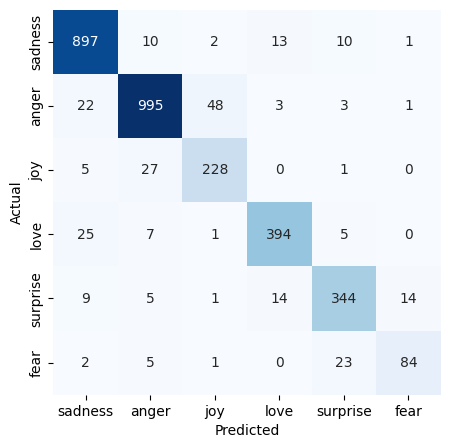

In [36]:
cm=confusion_matrix(y_true,y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,xticklabels=label2id.keys(),yticklabels=label2id.keys(),fmt="d",cbar=False,cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Build the Predictions and Save the Model

In [37]:
text="I Love that Comment"

def get_prediction(text):
  input_encoded=tokenizer(text,return_tensors="pt").to(device)

  with torch.no_grad():
    outputs=model(**input_encoded)

  logits=outputs.logits

  pred=torch.argmax(logits,dim=1).item()
  return id2label[pred]

get_prediction(text)

'love'

In [38]:
trainer.save_model("bert-base-uncased-sentiment-model")

## Used Pipeline for Predictions

In [39]:
from transformers import pipeline

In [40]:
text="Wow! .It was a amazing journey"

In [41]:
classifier=pipeline('text-classification',model='/content/bert-base-uncased-sentiment-model')

Device set to use cuda:0


In [42]:
classifier(text)

[{'label': 'joy', 'score': 0.7401763200759888}]